In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
physical_devices = tf.test.gpu_device_name()
print(physical_devices)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import datasets

import numpy as np

/device:GPU:0


c:\Users\Tim\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ds_preprocess_image(entity):
    img = entity["image"]
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    entity["image"] = resize
    return entity

In [3]:
def preprocess_image(img):
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    return np.array(resize)

In [4]:
preprocess = False
if preprocess:

    # load image data

    ds = datasets.load_from_disk("../../data/diffusion_and_real/")

    train_images = np.array([preprocess_image(image) for image in ds["train"]["image"]])
    train_labels = np.array(ds["train"]["label"])

    vali_images = np.array([preprocess_image(image) for image in ds["vali"]["image"]])
    vali_labels = np.array(ds["vali"]["label"])

    test_images = np.array([preprocess_image(image) for image in ds["test"]["image"]])
    test_labels = np.array(ds["test"]["label"])

    ds_map = ds.map(ds_preprocess_image)

    ds_tf = ds_map.with_format("tf")

    ds_tf.save_to_disk("ds-tf")
else:
    ds_tf = datasets.load_from_disk("ds-tf")

In [5]:
ds_tf_train = ds_tf["train"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_vali = ds_tf["vali"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_test = ds_tf["test"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

c:\Users\Tim\miniconda3\lib\site-packages\datasets\arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [6]:
ds_tf_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(8, (9, 9), activation='relu', input_shape=(512, 512, 3)))
#model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.AveragePooling2D((4, 4)))
# model.add(layers.Conv2D(32, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))


# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(3))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 504, 504, 8)       1952      
                                                                 
 average_pooling2d (AverageP  (None, 126, 126, 8)      0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 3)                 381027    
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 382,983
Trainable params: 382,983
Non-trainable params: 0
__________________________________________________

In [8]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 512, 512, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
conv2d (None, 512, 512, 3) float32
average_pooling2d (None, 504, 504, 8) float32
flatten (None, 126, 126, 8) float32
dense (None, 127008) float32
dense_1 (None, 3) float32


[None, None, None, None, None]

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # dear god let this be the right loss function
              metrics=['accuracy'])

history = model.fit(ds_tf_train, epochs=4, batch_size = 32, max_queue_size=10, shuffle=False,
                    validation_data=ds_tf_vali
                    )

Epoch 1/4
6000/6000 [==============================] - 204s 34ms/step - loss: 2.9530 - accuracy: 0.5400 - val_loss: 0.6785 - val_accuracy: 0.5230
Epoch 2/4
6000/6000 [==============================] - 200s 33ms/step - loss: 0.6684 - accuracy: 0.5621 - val_loss: 0.6722 - val_accuracy: 0.5770
Epoch 3/4
6000/6000 [==============================] - 202s 34ms/step - loss: 0.6222 - accuracy: 0.6126 - val_loss: 0.7562 - val_accuracy: 0.6030
Epoch 4/4
6000/6000 [==============================] - 197s 33ms/step - loss: 0.5518 - accuracy: 0.6659 - val_loss: 0.8103 - val_accuracy: 0.5750


In [10]:
model.save("CNN-2")

INFO:tensorflow:Assets written to: CNN-2\assets


INFO:tensorflow:Assets written to: CNN-2\assets


334/334 - 15s - loss: 0.9113 - accuracy: 0.5620 - 15s/epoch - 45ms/step


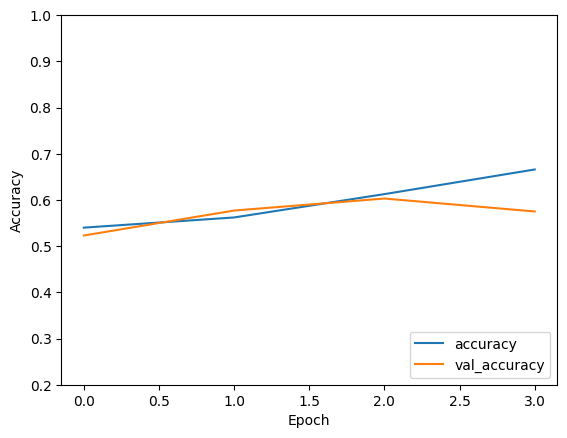

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_tf_test, verbose=2)


In [12]:
print(test_acc)


0.5619999766349792
